In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import cv2
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# Define parameters
img_width, img_height = 224, 224
batch_size = 32

In [ ]:
# Function to load images into arrays
def load_images_and_labels(directory, img_size=(224, 224)):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if os.path.isfile(file_path):
                    try:
                        img = cv2.imread(file_path)
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(subdir)
                    except Exception as e:
                        print(f"Error loading image: {file_path}, Error: {e}")
    return np.array(images), np.array(labels)

In [ ]:
# Load the dataset
from google.colab import drive
drive.mount("/content/drive")
dataset_path = "/content/drive/My Drive/combined_dataset"
X, y = load_images_and_labels(dataset_path, img_size=(img_width, img_height))

Mounted at /content/drive


In [ ]:
# Encode labels using one-hot encoding
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [ ]:
# Normalize pixel values (0 to 255) to (0 to 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Load VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional base
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(lb.classes_), activation='softmax'))

In [ ]:
# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model using preprocessed data without augmentation
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

Epoch 1/100
51/51 [==============================] - 45s 862ms/step - loss: 1.0983 - accuracy: 0.5460 - val_loss: 1.2329 - val_accuracy: 0.2261
Epoch 2/100
51/51 [==============================] - 43s 841ms/step - loss: 0.6043 - accuracy: 0.7453 - val_loss: 1.0473 - val_accuracy: 0.5855
Epoch 3/100
51/51 [==============================] - 43s 845ms/step - loss: 0.4782 - accuracy: 0.8143 - val_loss: 0.8819 - val_accuracy: 0.6913
Epoch 4/100
51/51 [==============================] - 42s 835ms/step - loss: 0.4068 - accuracy: 0.8354 - val_loss: 0.7365 - val_accuracy: 0.7623
Epoch 5/100
51/51 [==============================] - 42s 830ms/step - loss: 0.3719 - accuracy: 0.8528 - val_loss: 0.6023 - val_accuracy: 0.8246
Epoch 6/100
51/51 [==============================] - 42s 837ms/step - loss: 0.3316 - accuracy: 0.8689 - val_loss: 0.5013 - val_accuracy: 0.8638
Epoch 7/100
51/51 [==============================] - 43s 842ms/step - loss: 0.3038 - accuracy: 0.8901 - val_loss: 0.3880 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
predictions = model.predict(X_test, batch_size=batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:len(predicted_classes)], axis=1)

22/22 [==============================] - 14s 609ms/step


In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = lb.classes_
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Confusion Matrix:
[[ 92   0   3   0]
 [  0 270   1  13]
 [  0   0 164   2]
 [  0   8   3 134]]

Classification Report:
                       precision    recall  f1-score   support

 diseased cotton leaf       1.00      0.97      0.98        95
diseased cotton plant       0.97      0.95      0.96       284
    fresh cotton leaf       0.96      0.99      0.97       166
   fresh cotton plant       0.90      0.92      0.91       145

             accuracy                           0.96       690
            macro avg       0.96      0.96      0.96       690
         weighted avg       0.96      0.96      0.96       690



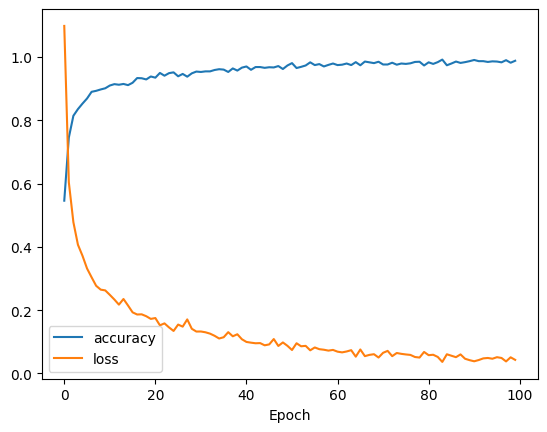

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

ROC AUC Score: 0.9954280664310942


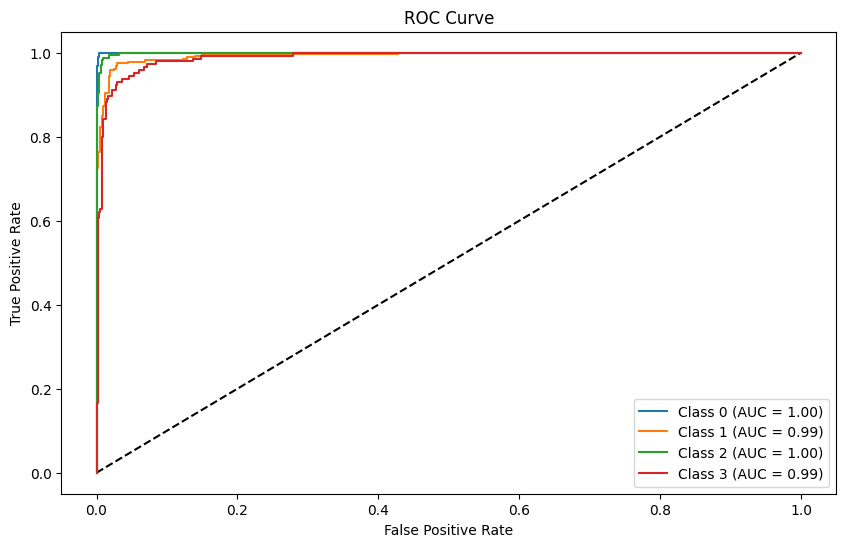

In [ ]:
# ROC AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc

roc_auc = roc_auc_score(true_classes, predictions, multi_class='ovr')
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(true_classes, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# 12min 10epoch

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test set
predictions = model.predict(X_test, batch_size=batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:len(predicted_classes)], axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision
precision = precision_score(true_classes, predicted_classes, average='macro')
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"F1 Score: {f1:.2f}")

# Classification report with all metrics
class_labels = lb.classes_
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


22/22 [==============================] - 13s 600ms/step
Confusion Matrix:
[[ 92   0   3   0]
 [  0 270   1  13]
 [  0   0 164   2]
 [  0   8   3 134]]
Accuracy: 95.65%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96

Classification Report:
                       precision    recall  f1-score   support

 diseased cotton leaf       1.00      0.97      0.98        95
diseased cotton plant       0.97      0.95      0.96       284
    fresh cotton leaf       0.96      0.99      0.97       166
   fresh cotton plant       0.90      0.92      0.91       145

             accuracy                           0.96       690
            macro avg       0.96      0.96      0.96       690
         weighted avg       0.96      0.96      0.96       690

